In [1]:
DEV = True
NUM_SAMPLES = 2314

TRAIN_TEST_RATIO = 0.3 # proportion of test data

import os
import numpy as np
import pandas as pd
import urllib
import zipfile
import xmltodict
from IPython.display import display

DATA_PATH = "data"
DATA_FILE = "speeches.json"
REMOTE_PATH = "http://adrien.barbaresi.eu/corpora/speeches/"
REMOTE_FILE = "German-political-speeches-2018-release.zip"
REMOTE_DATASET = "Bundesregierung.xml"
REMOTE_URL = REMOTE_PATH + REMOTE_FILE


def download_and_extract_data():
    zip_path = os.path.join(DATA_PATH, REMOTE_FILE)
    urllib.request.urlretrieve(REMOTE_URL, zip_path)
    with zipfile.ZipFile(zip_path) as file:
        file.extract(REMOTE_DATASET, path = DATA_PATH)


def load_data(reduced=True):
    if reduced:
        return pd.read_json(os.path.join(DATA_PATH, DATA_FILE))
    else:
        zip_path = os.path.join(DATA_PATH, REMOTE_FILE)
        if not os.path.isfile(zip_path):
            download_and_extract_data()
        file = os.path.join(DATA_PATH, REMOTE_DATASET) 
        with open(file, mode="rb") as file:
            xml_document = xmltodict.parse(file)
            text_nodes = xml_document['collection']['text']
            persons = [t['@person'] for t in text_nodes]
            speeches = [t['rohtext'] for t in text_nodes]
            return pd.DataFrame({'person' : persons, 'speech' : speeches})
        
        
df = load_data(reduced=False)

In [2]:
df.head()

,person,speech
0,Gerhard Schröder,"es ist angekündigt worden, man sollte im Beruf..."
1,Julian Nida-Rümelin,"Frau Präsidentin! An Sie gerichtet, Herr Börn..."
2,Gerhard Schröder,Frage (Peter Hahne): Bevor wir uns über den Au...
3,Gerhard Schröder,"Einen Satz von Ihnen, Herr Dr. Bernotat, habe ..."
4,Gerhard Schröder,diese Jahresversammlung der Hochschulrektorenk...


In [3]:
vc = df.person.value_counts()
vc

Angela Merkel              1125
Gerhard Schröder            418
Bernd Neumann               323
Monika Grütters             245
Christina Weiss             203
k.A.                         88
Michael Naumann              61
Julian Nida-Rümelin          47
Thomas de Maizière           43
Hans Martin Bury             42
Joschka Fischer              31
Rolf Schwanitz               24
Frank-Walter Steinmeier       7
Andere                        4
Jullian Nida-Rümelin          1
Name: person, dtype: int64

In [4]:
THRESHOLD = 100
toBeRemoved = [name for name in vc.index.tolist() if vc[name] < THRESHOLD]
df.drop(df[df.person.isin(toBeRemoved)].index, inplace=True)
df.person.value_counts()

Angela Merkel       1125
Gerhard Schröder     418
Bernd Neumann        323
Monika Grütters      245
Christina Weiss      203
Name: person, dtype: int64

In [5]:
df.loc[df['person'] != "Angela Merkel", ['person']] = 'Andere'
df.person.value_counts()

Andere           1189
Angela Merkel    1125
Name: person, dtype: int64

In [6]:
import spacy
from spacy.lang.de import STOP_WORDS
nlp = spacy.load("de_core_news_sm")
for word in nlp.Defaults.stop_words:
    for w in (word, word[0].upper() + word[1:], word.upper()):
        lex = nlp.vocab[w].is_stop = True
_ = nlp.disable_pipes("tagger", "parser", "ner")

In [7]:
ANALYSIS_FILE = "speeches.pickle"
ANALYSIS_PATH = os.path.join(DATA_PATH, ANALYSIS_FILE)

def analyze(speech):
    document = nlp(speech)
    token = [w.text for w in document]
    lemma = [w.lemma_ for w in document]
    return (token, lemma)
    
if not os.path.isfile(ANALYSIS_PATH):
    analysis = df.speech.map(analyze)
    df["tokens"] = analysis.apply(lambda x: x[0])
    df["lemmata"] = analysis.apply(lambda x: x[1])
    df.to_pickle(ANALYSIS_PATH)
else:
    df = pd.read_pickle(ANALYSIS_PATH)

In [8]:
df.head()

,person,speech,tokens,lemmata
0,Angela Merkel,"Sehr geehrter Herr Professor Franz,\nsehr geeh...","[Sehr, geehrter, Herr, Professor, Franz, ,, \n...","[Sehr, geehrt, Herr, Professor, franzen, ,, \n..."
1,Angela Merkel,"Sehr geehrter Herr Präsident Nakao, ich möchte...","[Sehr, geehrter, Herr, Präsident, Nakao, ,, ic...","[Sehr, geehrt, Herr, Präsident, Nakao, ,, ich,..."
2,Andere,Bei einer Fachtagung hat Kulturstaatsministeri...,"[Bei, einer, Fachtagung, hat, Kulturstaatsmini...","[Bei, einer, Fachtagung, haben, Kulturstaatsmi..."
3,Andere,Kulturstaatsministerin Grütters hat 12 kleine ...,"[Kulturstaatsministerin, Grütters, hat, 12, kl...","[Kulturstaatsministerin, Grütters, haben, 12, ..."
4,Andere,Die Luftfahrt ist in eine schwierige Situation...,"[Die, Luftfahrt, ist, in, eine, schwierige, Si...","[der, Luftfahrt, sein, in, einen, schwierige, ..."


In [9]:
from collections import Counter

def compute_word_index(speeches):
    sets = [set(speech) for speech in speeches]
    union = set.union(*sets)
    idx_2_word = [word for (index, word) in enumerate(union)]
    word_2_idx = {word:index for (index, word) in enumerate(union)}
    return (idx_2_word, word_2_idx)

def bag_of_words(speeches, index):
    return speeches.apply(lambda speech: {index[word]:1 for word in speech})

def count_words(speeches, index):
    return speeches.apply(lambda speech: {index[word]:count for (word, count) in Counter(speech).items()})

In [10]:
(words, index) = compute_word_index(df["lemmata"])
df["lemma_bow"] = bag_of_words(df["lemmata"], index)
df["lemma_counts"] = count_words(df["lemmata"], index)

In [11]:
df.iloc[0]

person                                              Angela Merkel
speech          Sehr geehrter Herr Professor Franz,\nsehr geeh...
tokens          [Sehr, geehrter, Herr, Professor, Franz, ,, \n...
lemmata         [Sehr, geehrt, Herr, Professor, franzen, ,, \n...
lemma_bow       {63329: 1, 26002: 1, 2549: 1, 38557: 1, 67944:...
lemma_counts    {63329: 2, 26002: 4, 2549: 5, 38557: 4, 67944:...
Name: 0, dtype: object

In [12]:
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import itertools

def dict_to_sparse(list_of_dicts, vocab_size):
    index_and_data = [(index, dictionary[index]) for dictionary in list_of_dicts for index in dictionary]
    index, data = zip(*index_and_data)
    lengths = [len(dictionary) for dictionary in list_of_dicts]
    row_pointers = list(itertools.accumulate([0] + lengths))
    return sparse.csr_matrix((data, index, row_pointers), shape=(len(list_of_dicts), vocab_size))

data = dict_to_sparse(df["lemma_counts"], len(index))
categories = df["person"].astype("category")
labels = categories.cat.codes

(0.762589928057554, array([[327,  30],
        [135, 203]]))

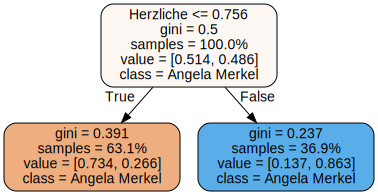

In [13]:
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import graphviz 

def make_decision_tree_classifier():
    return DecisionTreeClassifier(splitter="random", max_depth=1, criterion="gini")

def train_and_test(data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                    labels,
                                                    test_size = test_size,
                                                    stratify = labels)
    classifier = make_decision_tree_classifier()
    classifier.fit(train_data, train_labels)
    
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (classifier, accuracy, confusion)

(classifier, accuracy, confusion) = train_and_test(data, labels, test_size = TRAIN_TEST_RATIO)
display((accuracy, confusion))

def display_decision_tree(decision_tree_classifier):
    dot_data = sklearn.tree.export_graphviz(decision_tree_classifier, out_file=None,
                                            feature_names=words,
                                            class_names=categories,
                                            filled=True,
                                            proportion=True,
                                            rounded=True) 
    graph = graphviz.Source(dot_data) 
    display(graph)
    
display_decision_tree(classifier)

0.8690647482014389

array([[330,  27],
       [ 64, 274]])

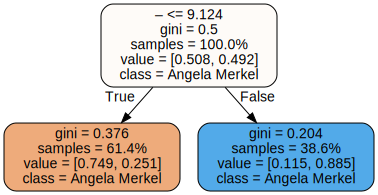

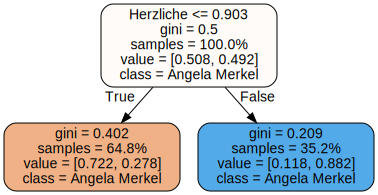

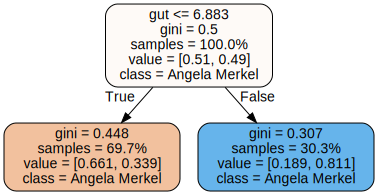

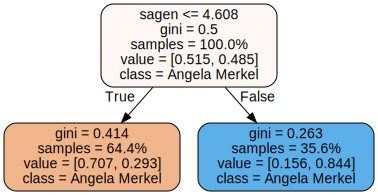

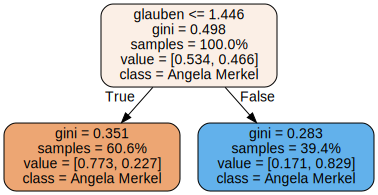

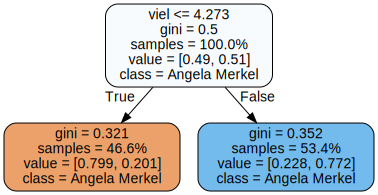

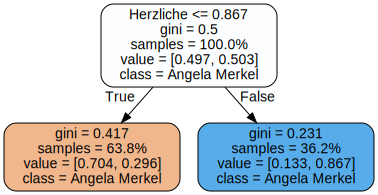

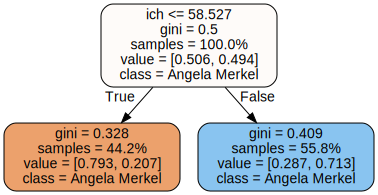

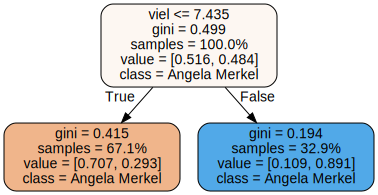

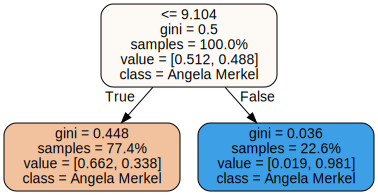

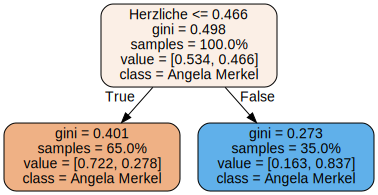

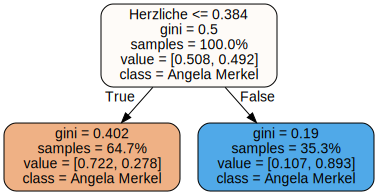

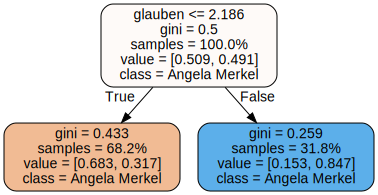

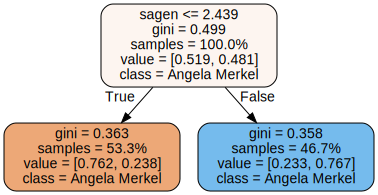

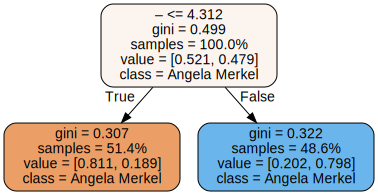

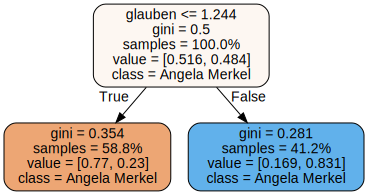

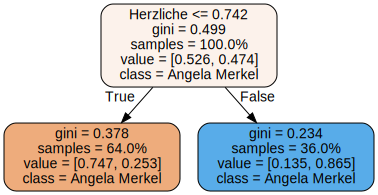

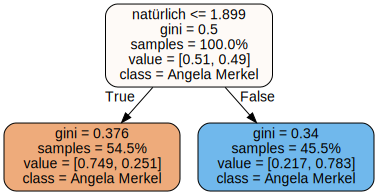

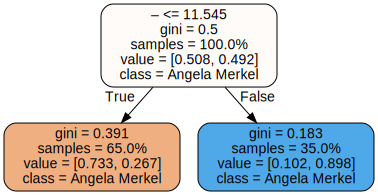

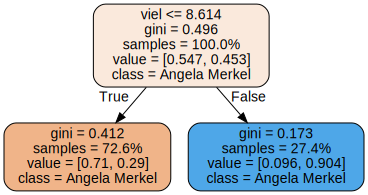

In [38]:
BOOST_FACTOR = 20

from sklearn.ensemble import BaggingClassifier


def train_and_test_bagged(data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                    labels,
                                                    test_size = test_size,
                                                    stratify = labels)
    ALL_CORES = -1
    classifier = BaggingClassifier(base_estimator = make_decision_tree_classifier(), n_estimators = BOOST_FACTOR, n_jobs=ALL_CORES)
    classifier.fit(train_data, train_labels)
    
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (classifier, accuracy, confusion)

(classifier, accuracy, confusion) = train_and_test_bagged(data, labels, test_size = TRAIN_TEST_RATIO)
display(accuracy, confusion)

for tree in classifier:
    display_decision_tree(tree)

0.9453237410071943

array([[347,  10],
       [ 28, 310]])

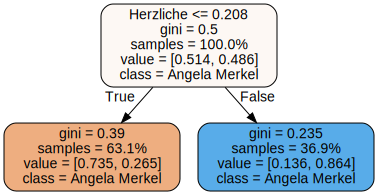

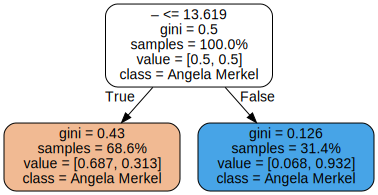

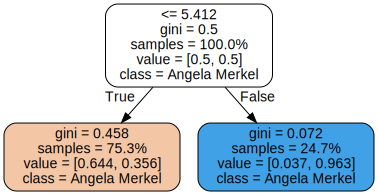

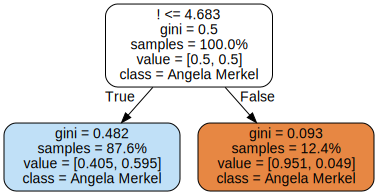

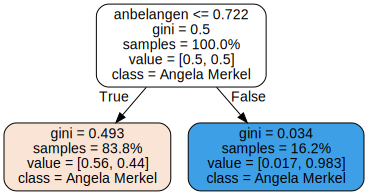

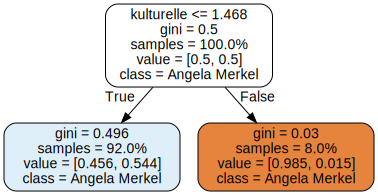

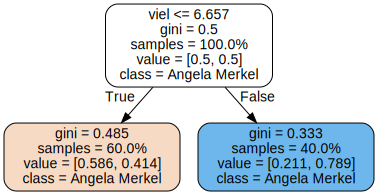

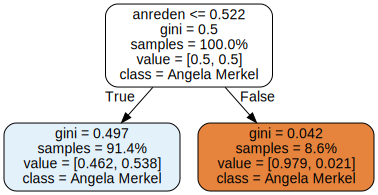

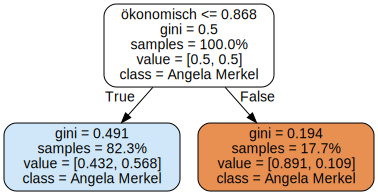

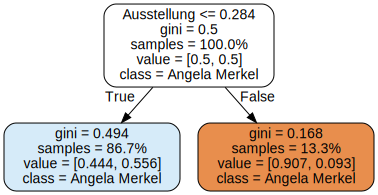

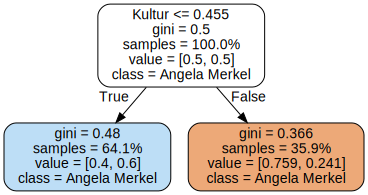

Error: <stdin>: syntax error in line 6 near '1'


CalledProcessError: Command '['dot', '-Tsvg']' returned non-zero exit status 1.

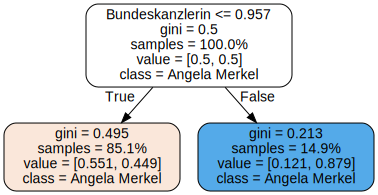

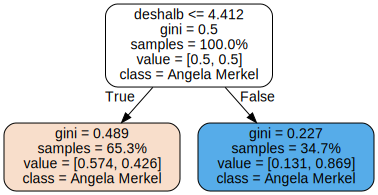

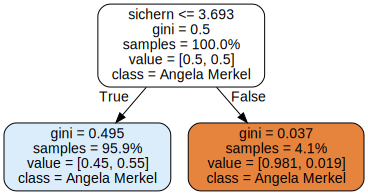

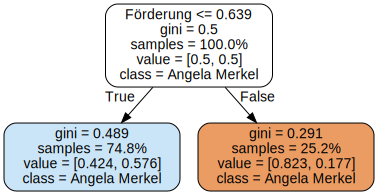

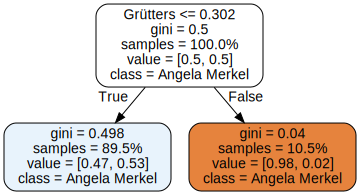

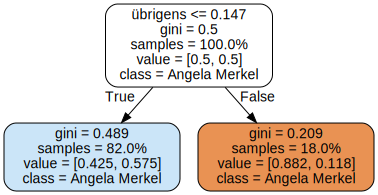

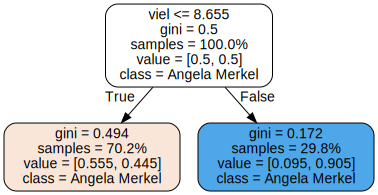

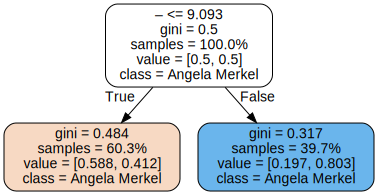

In [36]:
from sklearn.ensemble import AdaBoostClassifier

def train_and_test_boosted(data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                    labels,
                                                    test_size = test_size,
                                                    stratify = labels)
    classifier = AdaBoostClassifier(base_estimator = make_decision_tree_classifier(), n_estimators = BOOST_FACTOR)
    classifier.fit(train_data, train_labels)
    
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (classifier, accuracy, confusion)

(classifier, accuracy, confusion) = train_and_test_boosted(data, labels, test_size = TRAIN_TEST_RATIO)
display(accuracy, confusion)

for tree in classifier:
    display_decision_tree(tree)

0.9266187050359712

array([[343,  14],
       [ 37, 301]])

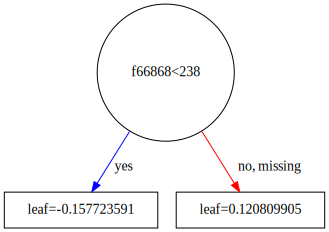

In [37]:
from xgboost import XGBClassifier
import xgboost
%matplotlib inline

def train_and_test_xgboost(data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                    labels,
                                                    test_size = test_size,
                                                    stratify = labels)
    classifier = XGBClassifier(max_depth = 1, n_estimators = BOOST_FACTOR)
    classifier.fit(train_data, train_labels)
    
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (classifier, accuracy, confusion)

(classifier, accuracy, confusion) = train_and_test_xgboost(data, labels, test_size = TRAIN_TEST_RATIO)
display(accuracy, confusion)

#for tree in classifier:
#    display_decision_tree(tree)
dot_data = xgboost.to_graphviz(classifier)
graph = graphviz.Source(dot_data) 
display(graph)